In [1]:
print("dd")

dd


In [3]:
import os
import shutil
import random
from glob import glob

# 1. 경로 설정
# 원본 데이터가 있는 경로
source_root = r'C:\Dev\KorailWheel\data\train' 
source_img_dir = os.path.join(source_root, 'images')
source_lbl_dir = os.path.join(source_root, 'labels')

# 결과가 저장될 경로 (새로 생성됨)
output_root = r'C:\Dev\KorailWheel\data\split_dataset'

# 2. 비율 설정 (7 : 1.5 : 1.5)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# 3. 결과 디렉토리 생성 함수
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 폴더 구조 생성: images/train, labels/train 등
for split in ['train', 'valid', 'test']:
    create_dir(os.path.join(output_root, 'images', split))
    create_dir(os.path.join(output_root, 'labels', split))

# 4. 파일 리스트 로드 및 셔플
# 이미지 확장자 (필요시 추가)
image_exts = ['.jpg', '.jpeg', '.png', '.bmp']
files = [f for f in os.listdir(source_img_dir) if os.path.splitext(f)[1].lower() in image_exts]

# 재현성을 위해 시드 고정 (선택 사항)
random.seed(42)
random.shuffle(files)

# 5. 분할 지점 계산
total_count = len(files)
train_idx = int(total_count * train_ratio)
valid_idx = train_idx + int(total_count * valid_ratio)

# 리스트 슬라이싱
train_files = files[:train_idx]
valid_files = files[train_idx:valid_idx]
test_files = files[valid_idx:]

print(f"총 파일 수: {total_count}")
print(f"Train: {len(train_files)} / Valid: {len(valid_files)} / Test: {len(test_files)}")
print("-" * 30)

# 6. 파일 복사 실행 함수
def copy_files(file_list, split_name):
    print(f"📂 {split_name} 데이터 복사 중...")
    for file_name in file_list:
        # 파일명과 확장자 분리
        name, ext = os.path.splitext(file_name)
        
        # 소스 경로
        src_img = os.path.join(source_img_dir, file_name)
        src_lbl = os.path.join(source_lbl_dir, name + '.txt')
        
        # 타겟 경로
        dst_img = os.path.join(output_root, 'images', split_name, file_name)
        dst_lbl = os.path.join(output_root, 'labels', split_name, name + '.txt')
        
        # 이미지 복사
        shutil.copy2(src_img, dst_img)
        
        # 라벨 복사 (라벨이 존재하는 경우만)
        if os.path.exists(src_lbl):
            shutil.copy2(src_lbl, dst_lbl)

# 실행
copy_files(train_files, 'train')
copy_files(valid_files, 'valid')
copy_files(test_files, 'test')

print("-" * 30)
print(f"✅ 데이터셋 분할 완료! 저장 경로: {output_root}")

총 파일 수: 368
Train: 257 / Valid: 55 / Test: 56
------------------------------
📂 train 데이터 복사 중...
📂 valid 데이터 복사 중...
📂 test 데이터 복사 중...
------------------------------
✅ 데이터셋 분할 완료! 저장 경로: C:\Dev\KorailWheel\data\split_dataset


In [2]:
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm  # 진행상황 표시용 (없으면 pip install tqdm)

# ==========================================
# 1. 설정 (경로 확인 필수)
# ==========================================
BASE_DIR = Path("C:/Dev/KorailWheel/data")  # 프로젝트 루트 경로
SOURCE_DIR = BASE_DIR / "total"        # 원본 소스 폴더
DEST_DIR = BASE_DIR / "data"           # 분할된 데이터가 저장될 폴더

# 시드 고정 (재현성을 위해)
random.seed(42)

# ==========================================
# 2. 파일 목록 읽기 및 분류
# ==========================================
image_dir = SOURCE_DIR / "images"
label_dir = SOURCE_DIR / "labels"

# 이미지 파일 확장자 목록
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

# 전체 이미지 리스트 가져오기
all_images = [
    f for f in image_dir.iterdir() 
    if f.suffix.lower() in valid_extensions and f.is_file()
]

print(f"총 이미지 개수: {len(all_images)}장")

# 그룹 분류
# 'img'로 시작하는 파일 (고품질/오토라벨 보정본 추정) -> Valid/Test 후보
candidates = [img for img in all_images if img.name.lower().startswith("img")]

# 그 외 파일 (수동 라벨링 등) -> 무조건 Train
others = [img for img in all_images if not img.name.lower().startswith("img")]

print(f"- 'img'로 시작하는 파일(후보군): {len(candidates)}장")
print(f"- 그 외 파일(Train 확정): {len(others)}장")

# ==========================================
# 3. 데이터 분할 (Split)
# ==========================================
# 후보군이 최소 100장은 넘어야 함 (Valid 50 + Test 50)
if len(candidates) < 100:
    raise ValueError(f"오류: 'img'로 시작하는 파일이 100장 미만입니다. ({len(candidates)}장)")

# 랜덤 셔플
random.shuffle(candidates)

# 50장씩 뽑기
valid_set = candidates[:50]
test_set = candidates[50:100]

# 나머지는 모두 Train으로
train_from_candidates = candidates[100:]
train_set = train_from_candidates + others

print("\n[데이터셋 분할 결과]")
print(f"- Train : {len(train_set)}장 (나머지 img파일 + 그 외 파일)")
print(f"- Valid : {len(valid_set)}장 (img파일 중 랜덤 50장)")
print(f"- Test  : {len(test_set)}장 (img파일 중 랜덤 50장)")

# ==========================================
# 4. 파일 복사 실행
# ==========================================
def copy_files(file_list, split_name):
    # 저장할 경로 생성 (예: data/train/images)
    save_img_dir = DEST_DIR / split_name / "images"
    save_lbl_dir = DEST_DIR / split_name / "labels"
    
    save_img_dir.mkdir(parents=True, exist_ok=True)
    save_lbl_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\nProcessing {split_name} data...")
    
    for img_path in tqdm(file_list):
        # 1. 이미지 복사
        shutil.copy2(img_path, save_img_dir / img_path.name)
        
        # 2. 라벨 복사 (짝이 맞는 txt 파일 찾기)
        label_name = img_path.stem + ".txt"
        label_src = label_dir / label_name
        
        if label_src.exists():
            shutil.copy2(label_src, save_lbl_dir / label_name)
        else:
            # 라벨이 없는 경우 경고 (필요 시 주석 해제)
            # print(f"Warning: Label not found for {img_path.name}")
            pass

# 기존 data 폴더가 있다면 삭제 후 재생성 (깨끗한 상태 유지)
if DEST_DIR.exists():
    shutil.rmtree(DEST_DIR)
    print(f"\n기존 {DEST_DIR} 폴더를 삭제하고 새로 생성합니다.")

# 복사 수행
copy_files(train_set, "train")
copy_files(valid_set, "valid")
copy_files(test_set, "test")

print("\n✅ 모든 작업이 완료되었습니다! 'data' 폴더를 확인하세요.")

총 이미지 개수: 368장
- 'img'로 시작하는 파일(후보군): 268장
- 그 외 파일(Train 확정): 100장

[데이터셋 분할 결과]
- Train : 268장 (나머지 img파일 + 그 외 파일)
- Valid : 50장 (img파일 중 랜덤 50장)
- Test  : 50장 (img파일 중 랜덤 50장)

Processing train data...


100%|██████████| 268/268 [00:00<00:00, 272.84it/s]



Processing valid data...


100%|██████████| 50/50 [00:00<00:00, 268.89it/s]



Processing test data...


100%|██████████| 50/50 [00:00<00:00, 301.07it/s]


✅ 모든 작업이 완료되었습니다! 'data' 폴더를 확인하세요.


In [1]:
# build_patch_lib.py
from pathlib import Path
import cv2
import numpy as np
import pandas as pd

from config import ROOT

# -------------------------
# Settings (ONLY here)
# -------------------------
SRC_DIR = ROOT / "data" / "patch_all"          # images/, labels/
OUT_DIR = ROOT / "data" / "patch"              # train/valid/test 생성

SEED = 0
RATIO_TRAIN = 0.70
RATIO_VALID = 0.15
RATIO_TEST  = 0.15

# patch crop 옵션
MARGIN = 16                 # 인스턴스 bbox 바깥 여유 픽셀
MIN_MASK_AREA = 120         # 너무 작은 인스턴스(노이즈) 제거
APPROX_EPS = 2.0            # contour 폴리곤 단순화 정도(픽셀)

# 클래스 필터(필요시)
# None이면 모든 클래스 추출, 예: {0} 처럼 지정하면 해당 cls만 추출
KEEP_CLASSES = None

# 출력 포맷
IMG_EXT = ".png"            # crop 저장 확장자


# -------------------------
# Utils
# -------------------------
def _img_list(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    return sorted([p for p in folder.rglob("*") if p.suffix.lower() in exts])


def _read_yolo_seg_instances(label_path: Path):
    """
    YOLOv8-seg line: cls xc yc w h x1 y1 x2 y2 ... (normalized)
    return: list[(cls:int, poly_norm:(N,2) float32)]
    """
    if not label_path.exists():
        return []
    txt = label_path.read_text(encoding="utf-8").strip()
    if not txt:
        return []

    inst = []
    for line in txt.splitlines():
        p = line.strip().split()
        if len(p) < 6:
            continue
        cls = int(float(p[0]))
        coords = np.array(list(map(float, p[5:])), dtype=np.float32)
        if coords.size >= 6:
            poly = coords.reshape(-1, 2)
            inst.append((cls, poly))
    return inst


def _poly_to_mask(poly_norm: np.ndarray, w: int, h: int):
    m = np.zeros((h, w), dtype=np.uint8)
    pts = poly_norm.copy()
    pts[:, 0] = np.clip(pts[:, 0] * w, 0, w - 1)
    pts[:, 1] = np.clip(pts[:, 1] * h, 0, h - 1)
    pts = pts.astype(np.int32)
    if pts.shape[0] >= 3:
        cv2.fillPoly(m, [pts], 1)
    return m


def _crop_with_margin(img, mask01, margin):
    ys, xs = np.where(mask01 > 0)
    if ys.size == 0:
        return None
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    H, W = mask01.shape
    x0 = max(0, int(x0) - margin)
    y0 = max(0, int(y0) - margin)
    x1 = min(W - 1, int(x1) + margin)
    y1 = min(H - 1, int(y1) + margin)

    crop_img = img[y0:y1+1, x0:x1+1].copy()
    crop_m   = mask01[y0:y1+1, x0:x1+1].copy()
    return crop_img, crop_m, x0, y0


def _mask_to_yolo_seg_line(mask01_crop, cls_id):
    """
    crop 마스크에서 contour 기반으로 (bbox + polygon) YOLOv8-seg 라인 생성
    return: str or None
    """
    m = (mask01_crop > 0).astype(np.uint8)
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(cnt) < MIN_MASK_AREA:
        return None

    # polygon 단순화
    eps = APPROX_EPS
    approx = cv2.approxPolyDP(cnt, eps, True)
    if approx.shape[0] < 3:
        return None

    H, W = m.shape[:2]
    pts = approx.reshape(-1, 2).astype(np.float32)
    pts[:, 0] = np.clip(pts[:, 0], 0, W - 1)
    pts[:, 1] = np.clip(pts[:, 1], 0, H - 1)

    # bbox from contour
    x, y, bw, bh = cv2.boundingRect(cnt)
    xc = (x + bw / 2) / W
    yc = (y + bh / 2) / H
    bw_n = bw / W
    bh_n = bh / H

    # polygon normalized
    pts_n = pts.copy()
    pts_n[:, 0] = pts_n[:, 0] / W
    pts_n[:, 1] = pts_n[:, 1] / H

    # line
    vals = [f"{cls_id:d}", f"{xc:.6f}", f"{yc:.6f}", f"{bw_n:.6f}", f"{bh_n:.6f}"]
    for (px, py) in pts_n:
        vals.append(f"{px:.6f}")
        vals.append(f"{py:.6f}")
    return " ".join(vals)


def _make_splits(src_stems, seed, r_tr, r_va, r_te):
    rng = np.random.default_rng(seed)
    stems = np.array(sorted(list(src_stems)))
    rng.shuffle(stems)

    n = len(stems)
    n_tr = int(round(n * r_tr))
    n_va = int(round(n * r_va))
    n_te = n - n_tr - n_va

    tr = set(stems[:n_tr])
    va = set(stems[n_tr:n_tr + n_va])
    te = set(stems[n_tr + n_va:])

    return tr, va, te


def main():
    img_dir = SRC_DIR / "images"
    lab_dir = SRC_DIR / "labels"

    imgs = _img_list(img_dir)
    # "라벨 있는 원본"만 split 기준으로 쓰는 게 안정적
    labeled = []
    for p in imgs:
        if (lab_dir / f"{p.stem}.txt").exists():
            labeled.append(p)

    src_stems = {p.stem for p in labeled}
    tr_set, va_set, te_set = _make_splits(src_stems, SEED, RATIO_TRAIN, RATIO_VALID, RATIO_TEST)

    def _split_of(stem):
        if stem in tr_set: return "train"
        if stem in va_set: return "valid"
        return "test"

    # output dirs
    for sp in ["train", "valid", "test"]:
        (OUT_DIR / sp / "images").mkdir(parents=True, exist_ok=True)
        (OUT_DIR / sp / "labels").mkdir(parents=True, exist_ok=True)
        (OUT_DIR / sp / "masks").mkdir(parents=True, exist_ok=True)

    # save split mapping (src image 기준)
    split_rows = []
    for stem in sorted(src_stems):
        split_rows.append({"src_stem": stem, "split": _split_of(stem)})
    pd.DataFrame(split_rows).to_csv(OUT_DIR / "splits_src.csv", index=False, encoding="utf-8-sig")

    # extract instances
    manifest = []
    for img_path in labeled:
        stem = img_path.stem
        split = _split_of(stem)

        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]

        inst = _read_yolo_seg_instances(lab_dir / f"{stem}.txt")
        if KEEP_CLASSES is not None:
            inst = [(c, p) for (c, p) in inst if c in KEEP_CLASSES]

        for k, (cls_id, poly_norm) in enumerate(inst):
            mask01 = _poly_to_mask(poly_norm, W, H)
            area = int(mask01.sum())
            if area < MIN_MASK_AREA:
                continue

            cropped = _crop_with_margin(img, mask01, MARGIN)
            if cropped is None:
                continue
            crop_img, crop_m, x0, y0 = cropped

            yolo_line = _mask_to_yolo_seg_line(crop_m, cls_id)
            if yolo_line is None:
                continue

            out_stem = f"{stem}_i{k:02d}_c{cls_id}"
            out_img = OUT_DIR / split / "images" / f"{out_stem}{IMG_EXT}"
            out_lab = OUT_DIR / split / "labels" / f"{out_stem}.txt"
            out_msk = OUT_DIR / split / "masks"  / f"{out_stem}.png"

            cv2.imwrite(str(out_img), crop_img)
            cv2.imwrite(str(out_msk), (crop_m > 0).astype(np.uint8) * 255)
            out_lab.write_text(yolo_line + "\n", encoding="utf-8")

            manifest.append({
                "split": split,
                "src_image": str(img_path),
                "src_stem": stem,
                "inst_idx": k,
                "cls": cls_id,
                "area": area,
                "crop_x0": int(x0),
                "crop_y0": int(y0),
                "crop_w": int(crop_img.shape[1]),
                "crop_h": int(crop_img.shape[0]),
                "out_image": str(out_img),
                "out_mask": str(out_msk),
                "out_label": str(out_lab),
            })

    pd.DataFrame(manifest).to_csv(OUT_DIR / "manifest.csv", index=False, encoding="utf-8-sig")

    print("DONE")
    print("Saved splits:", OUT_DIR / "splits_src.csv")
    print("Saved manifest:", OUT_DIR / "manifest.csv")
    df = pd.DataFrame(manifest)
    if len(df):
        print(df.groupby("split").size())
    else:
        print("No instances extracted. Check labels/classes/min_area.")


if __name__ == "__main__":
    main()


DONE
Saved splits: C:\Dev\KorailWheel\data\patch\splits_src.csv
Saved manifest: C:\Dev\KorailWheel\data\patch\manifest.csv
split
test     25
train    85
valid    21
dtype: int64


In [4]:
from pathlib import Path
base = Path(r"C:\Dev\KorailWheel\data\st1_roi")

In [5]:
def _wheel_id_quick(p: Path):
    # 파일명 규칙에 맞게 수정: 기본은 첫 '_' 전까지
    s = p.stem
    return s.split("_")[0] if "_" in s else s

In [7]:
def _img_list(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    return sorted([p for p in folder.rglob("*") if p.suffix.lower() in exts])


In [8]:

sets = {}
for sp in ["train", "valid", "test"]:
    imgs = _img_list(base / sp / "images")
    sets[sp] = set(_wheel_id_quick(p) for p in imgs)

inter_tv = sets["train"] & sets["valid"]
inter_tt = sets["train"] & sets["test"]
inter_vt = sets["valid"] & sets["test"]

print("train wheels:", len(sets["train"]))
print("valid wheels:", len(sets["valid"]))
print("test  wheels:", len(sets["test"]))
print("overlap train-valid:", len(inter_tv))
print("overlap train-test :", len(inter_tt))
print("overlap valid-test :", len(inter_vt))
if len(inter_tv)+len(inter_tt)+len(inter_vt) > 0:
    print("LEAKAGE: wheel_id overlap exists")
else:
    print("OK: no wheel_id overlap")



train wheels: 268
valid wheels: 50
test  wheels: 50
overlap train-valid: 0
overlap train-test : 0
overlap valid-test : 0
OK: no wheel_id overlap


In [15]:
import os, random, glob, math
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# =========================
# 경로만 본인 환경으로 수정
# =========================
# 합성 데이터셋(타일+라벨)
SYN_ROOT = Path(r"C:\Dev\KorailWheel\data\data_tiles_synth")  # OUT_DIR
SYN_TRAIN_IMG = SYN_ROOT / "train" / "images"
SYN_TRAIN_LAB = SYN_ROOT / "train" / "labels"

SYN_VALID_IMG = SYN_ROOT / "valid" / "images"
SYN_VALID_LAB = SYN_ROOT / "valid" / "labels"

SYN_TEST_IMG  = SYN_ROOT / "test" / "images"
SYN_TEST_LAB  = SYN_ROOT / "test" / "labels"

# 실결함 타일(가능하면 tile단위 defect set) - 없으면 external_test defect tiles 사용
REAL_DEFECT_DIR = Path(r"C:\Dev\KorailWheel\data\data_tiles\external_test\defect\images")

# 실정상 타일 (optional)
REAL_NORMAL_DIR = Path(r"C:\Dev\KorailWheel\data\data_tiles\external_test\normal\images")

# 타일 크기(현재 512)
TILE_SIZE = 512

def list_imgs(d: Path):
    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    if not d.exists():
        return []
    return sorted([p for p in d.rglob("*") if p.suffix.lower() in exts])

print("SYN train imgs:", len(list_imgs(SYN_TRAIN_IMG)))
print("REAL defect imgs:", len(list_imgs(REAL_DEFECT_DIR)))


SYN train imgs: 5157
REAL defect imgs: 159


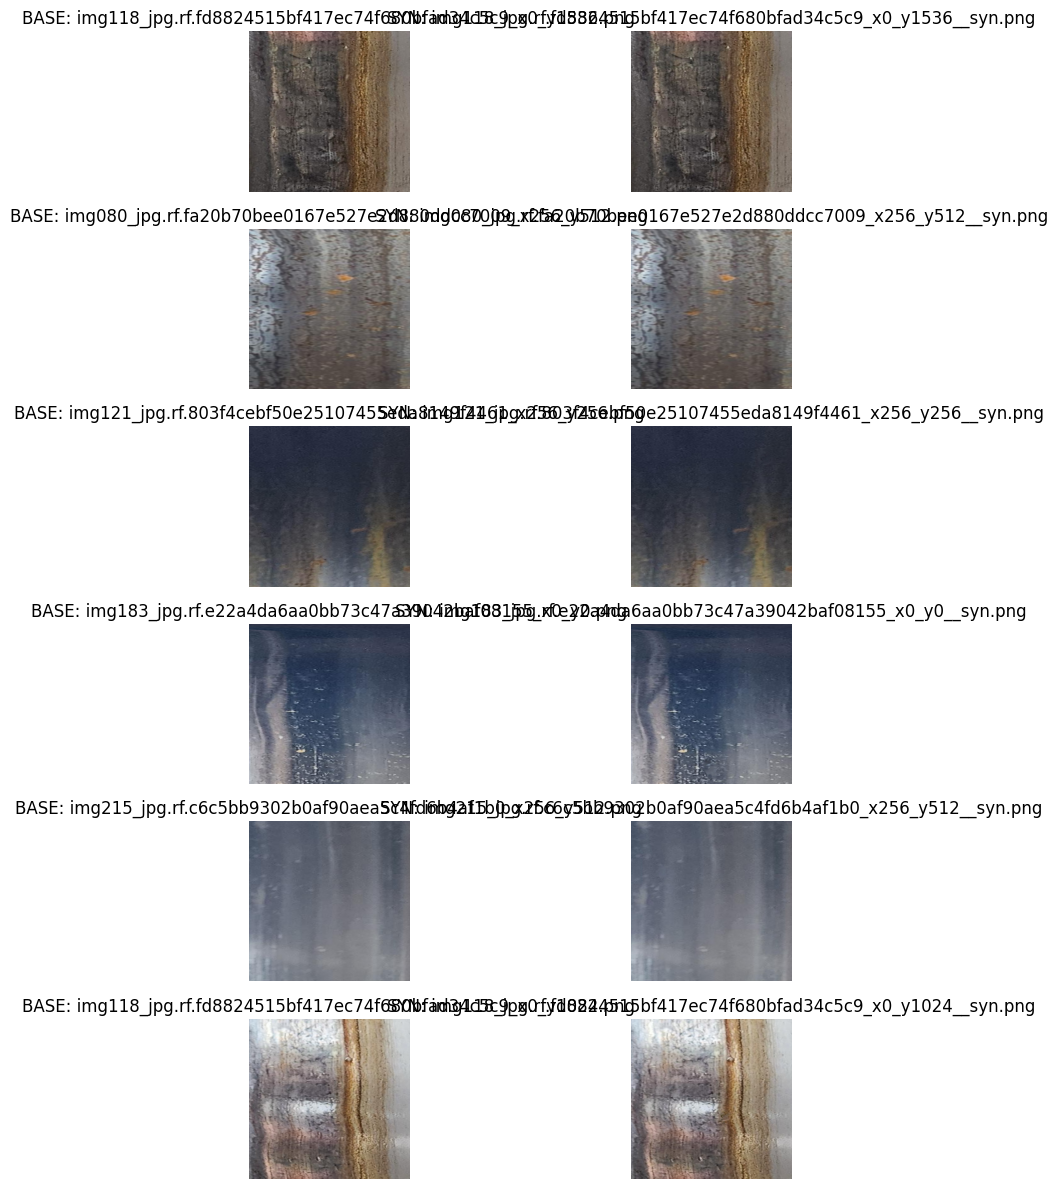

In [16]:
def read_bgr(p):
    img = cv2.imread(str(p), cv2.IMREAD_COLOR)
    return img

def show_pairs(img_dir: Path, n=8, seed=0):
    rng = random.Random(seed)
    syns = [p for p in list_imgs(img_dir) if p.name.endswith("__syn.png")]
    rng.shuffle(syns)
    syns = syns[:n]

    plt.figure(figsize=(10, 2*n))
    for i, syn_path in enumerate(syns, 1):
        base_name = syn_path.name.replace("__syn.png", ".png")  # 원본이 png로 복사된다고 가정
        base_path = syn_path.parent / base_name
        syn = read_bgr(syn_path)
        base = read_bgr(base_path) if base_path.exists() else None

        # BGR->RGB for display
        syn_rgb = cv2.cvtColor(syn, cv2.COLOR_BGR2RGB) if syn is not None else None
        if base is not None:
            base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
        else:
            base_rgb = np.zeros_like(syn_rgb)

        plt.subplot(n, 2, 2*i-1)
        plt.imshow(base_rgb); plt.axis("off")
        plt.title(f"BASE: {base_path.name if base_path.exists() else 'MISSING'}")

        plt.subplot(n, 2, 2*i)
        plt.imshow(syn_rgb); plt.axis("off")
        plt.title(f"SYN: {syn_path.name}")

    plt.tight_layout()
    plt.show()

show_pairs(SYN_TEST_IMG, n=6, seed=1)


In [17]:
def yolo_seg_to_mask(label_path: Path, W=512, H=512):
    """
    YOLO-seg line: cls x y w h x1 y1 x2 y2 ...  (x,y are normalized)
    여러 객체가 있으면 union mask로 합침
    """
    mask = np.zeros((H, W), dtype=np.uint8)
    if not label_path.exists():
        return mask

    txt = label_path.read_text(encoding="utf-8").strip()
    if not txt:
        return mask

    for line in txt.splitlines():
        p = line.strip().split()
        if len(p) <= 6:
            continue
        coords = np.array(list(map(float, p[5:])), dtype=np.float32).reshape(-1, 2)
        pts = coords.copy()
        pts[:, 0] = np.clip(pts[:, 0] * W, 0, W-1)
        pts[:, 1] = np.clip(pts[:, 1] * H, 0, H-1)
        pts = np.round(pts).astype(np.int32)
        if pts.shape[0] >= 3:
            cv2.fillPoly(mask, [pts], 1)
    return mask


In [18]:
def boundary_ring(mask01, r=3):
    """
    mask 경계 주변 링: dilate - erode
    """
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*r+1, 2*r+1))
    dil = cv2.dilate(mask01.astype(np.uint8), k, iterations=1)
    ero = cv2.erode(mask01.astype(np.uint8), k, iterations=1)
    ring = ((dil > 0) & (ero == 0)).astype(np.uint8)
    return ring

def grad_mag(gray):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)
    return mag

def deltaE_lab(img_bgr, m_in, m_out):
    """
    inside vs outside 평균 Lab 차이(ΔE76)
    """
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    if m_in.sum() < 20 or m_out.sum() < 20:
        return np.nan
    Lin = lab[m_in>0].mean(axis=0)
    Lout = lab[m_out>0].mean(axis=0)
    de = float(np.linalg.norm(Lin - Lout))
    return de

def seam_scores(img_bgr, mask01, ring_r=3, in_r=5, out_r=5):
    """
    - ring_grad_mean: 경계 링의 gradient 평균
    - in_grad_mean / out_grad_mean: 경계 안/밖 근처 gradient 평균
    - de_inout: 경계 안/밖 평균 Lab 색차
    """
    H, W = mask01.shape
    ring = boundary_ring(mask01, r=ring_r)

    # inside band: erode(ring_r+in_r)로 너무 안쪽으로 들어가지 않게 "경계 안쪽 띠" 구성
    k_in = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*(ring_r+in_r)+1, 2*(ring_r+in_r)+1))
    inside = cv2.erode(mask01.astype(np.uint8), k_in, iterations=1)
    inside_band = ((mask01>0) & (inside==0)).astype(np.uint8)

    # outside band: dilate 후 mask 제외
    k_out = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*(ring_r+out_r)+1, 2*(ring_r+out_r)+1))
    outside = cv2.dilate(mask01.astype(np.uint8), k_out, iterations=1)
    outside_band = ((outside>0) & (mask01==0)).astype(np.uint8)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    mag = grad_mag(gray)

    def safe_mean(x, m):
        if m.sum() < 20:
            return np.nan
        return float(x[m>0].mean())

    ring_grad = safe_mean(mag, ring)
    in_grad   = safe_mean(mag, inside_band)
    out_grad  = safe_mean(mag, outside_band)

    de = deltaE_lab(img_bgr, inside_band, outside_band)

    return ring_grad, in_grad, out_grad, de


usable syn samples: 157


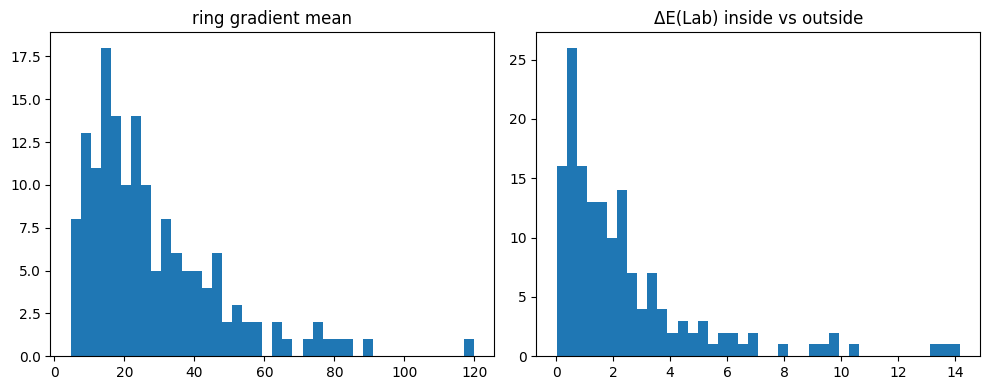

ring_grad mean/std: 28.129963 19.211636
ΔE mean/std: 2.4590774 2.6387749


In [19]:
def collect_seam_stats(img_dir: Path, lab_dir: Path, max_n=400, seed=0):
    syns = [p for p in list_imgs(img_dir) if p.name.endswith("__syn.png")]
    random.Random(seed).shuffle(syns)
    syns = syns[:max_n]

    rows = []
    for p in syns:
        img = read_bgr(p)
        if img is None:
            continue
        lab = lab_dir / f"{p.stem}.txt"
        m = yolo_seg_to_mask(lab, W=TILE_SIZE, H=TILE_SIZE)
        if m.sum() < 30:  # 결함 너무 작거나 라벨 없으면 제외
            continue
        ring_grad, in_grad, out_grad, de = seam_scores(img, m, ring_r=3)
        rows.append((p.name, ring_grad, in_grad, out_grad, de, int(m.sum())))
    return rows

rows = collect_seam_stats(SYN_TEST_IMG, SYN_TEST_LAB, max_n=300, seed=1)
print("usable syn samples:", len(rows))

arr = np.array([[r[1], r[2], r[3], r[4]] for r in rows], dtype=np.float32)
ring_grad = arr[:,0]; in_grad = arr[:,1]; out_grad = arr[:,2]; de = arr[:,3]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(ring_grad[~np.isnan(ring_grad)], bins=40); plt.title("ring gradient mean")
plt.subplot(1,2,2); plt.hist(de[~np.isnan(de)], bins=40); plt.title("ΔE(Lab) inside vs outside")
plt.tight_layout(); plt.show()

print("ring_grad mean/std:", np.nanmean(ring_grad), np.nanstd(ring_grad))
print("ΔE mean/std:", np.nanmean(de), np.nanstd(de))


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# ResNet18 feature extractor (frozen)
res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device).eval()
for p in res.parameters():
    p.requires_grad = False
feat_net = nn.Sequential(*(list(res.children())[:-1])).to(device).eval()  # [B,512,1,1]

tfm = transforms.Compose([
    transforms.ToTensor(),  # 0~1, RGB
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def load_rgb_512(p):
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        return None
    bgr = cv2.resize(bgr, (TILE_SIZE, TILE_SIZE), interpolation=cv2.INTER_AREA)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

class RealSynthDS(Dataset):
    def __init__(self, real_dir: Path, syn_dir: Path, n_max=800, seed=0):
        real = list_imgs(real_dir)
        syn  = [p for p in list_imgs(syn_dir) if p.name.endswith("__syn.png")]
        rnd = random.Random(seed)
        rnd.shuffle(real); rnd.shuffle(syn)
        real = real[:n_max]
        syn  = syn[:n_max]
        self.items = [(p, 1) for p in real] + [(p, 0) for p in syn]  # 1=real defect, 0=synth defect
        rnd.shuffle(self.items)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        p, y = self.items[i]
        rgb = load_rgb_512(p)
        x = tfm(rgb).float()
        return x, torch.tensor(y).long()

def extract_feats(dl):
    X, Y = [], []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            f = feat_net(x).squeeze(-1).squeeze(-1)  # [B,512]
            X.append(f.cpu())
            Y.append(y)
    return torch.cat(X, 0), torch.cat(Y, 0)

# 데이터 준비
ds = RealSynthDS(REAL_DEFECT_DIR, SYN_TEST_IMG, n_max=500, seed=0)
n = len(ds)
n_train = int(0.8*n)
train_ds, test_ds = torch.utils.data.random_split(ds, [n_train, n-n_train], generator=torch.Generator().manual_seed(0))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

Xtr, Ytr = extract_feats(train_dl)
Xte, Yte = extract_feats(test_dl)

# 선형 분류기
clf = nn.Linear(Xtr.shape[1], 2).to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
ce = nn.CrossEntropyLoss()

Xtr_d = Xtr.to(device); Ytr_d = Ytr.to(device)
Xte_d = Xte.to(device); Yte_d = Yte.to(device)

for epoch in range(20):
    clf.train()
    opt.zero_grad()
    logits = clf(Xtr_d)
    loss = ce(logits, Ytr_d)
    loss.backward()
    opt.step()

    if (epoch+1) % 5 == 0:
        clf.eval()
        with torch.no_grad():
            pred = clf(Xte_d).argmax(1)
            acc = (pred == Yte_d).float().mean().item()
        print(f"epoch {epoch+1:02d} | loss {loss.item():.4f} | test acc {acc*100:.2f}%")


epoch 05 | loss 0.7092 | test acc 43.75%
epoch 10 | loss 0.6202 | test acc 54.69%
epoch 15 | loss 0.5585 | test acc 68.75%
epoch 20 | loss 0.5133 | test acc 68.75%


In [1]:
import cv2
import numpy as np
import shutil
from pathlib import Path
from tqdm import tqdm

# ============================
# 사용자 설정 (경로 수정 필수)
# ============================
ROOT_DIR = Path(r"C:\Dev\KorailWheel\data")

# 1. 실제 결함 8장이 있는 폴더 (이미지 + 라벨 txt)
REAL_IMG_DIR = ROOT_DIR / "st1_roi" / "external_test"  / "images"
REAL_LAB_DIR = ROOT_DIR / "st1_roi" / "external_test"  / "labels"

# 2. 분석할 기존 패치 폴더
PATCH_DIR = ROOT_DIR / "patch" / "train" / "images" # (필요시 valid/test도 수행)
PATCH_LAB_DIR = ROOT_DIR / "patch" / "train" / "labels"

# 3. 걸러낸 '정예 패치'를 저장할 곳
OUT_DIR = ROOT_DIR / "patch_clean" / "train"
OUT_IMG_DIR = OUT_DIR / "images"
OUT_LAB_DIR = OUT_DIR / "labels"

# 4. 필터링 기준
MIN_PIXELS = 50           # 너무 작은 먼지 제거 (Area < 50 px)
MAX_RECTANGULARITY = 0.95 # 1.0에 가까우면 '네모난 박스' 마스크 (불량)
MIN_TEXTURE_VAR = 10.0    # 너무 매끈하면(단색/블러) 제거 (Laplacian Variance)

# ============================

def get_yolo_polygons(lab_path, h, w):
    """ YOLO txt 라벨에서 폴리곤 좌표 복원 """
    if not lab_path.exists(): return []
    
    with open(lab_path, 'r') as f:
        lines = f.readlines()
        
    polys = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        if len(parts) < 5: continue # seg 정보 없음
        
        # class x y w h x1 y1 x2 y2 ...
        coords = np.array(parts[5:]).reshape(-1, 2)
        # 정규화 -> 픽셀 좌표
        coords[:, 0] *= w
        coords[:, 1] *= h
        polys.append(coords.astype(np.int32))
    return polys

def analyze_crop(img, mask):
    """ 이미지 조각(Crop)의 특성 분석 """
    # 1. 텍스처 (선명도/거칠기)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 마스크 영역만 추출
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    
    # Laplacian Variance (높을수록 거칠고 선명함)
    # 마스크 내부 픽셀만 계산
    pixels = masked_gray[mask > 0]
    if len(pixels) == 0: return 0, 0, 0
    
    mean_val = np.mean(pixels)
    std_val = np.std(pixels) # 대비(Contrast)
    
    # 간단한 텍스처 지표: Laplacian의 분산
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap_var = lap[mask > 0].var() if len(pixels) > 0 else 0
    
    return mean_val, std_val, lap_var

def main():
    # 폴더 생성
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    OUT_LAB_DIR.mkdir(parents=True, exist_ok=True)
    
    # -------------------------------------------------
    # Step 1. 실제 결함(Real Defect) 특성 파악 (Golden Standard)
    # -------------------------------------------------
    print(">>> [1/3] 실제 결함 8장 분석 중...")
    real_stats = {'mean': [], 'std': [], 'lap': []}
    
    real_imgs = list(REAL_IMG_DIR.glob("*.png")) + list(REAL_IMG_DIR.glob("*.jpg"))
    if not real_imgs:
        print("!! 경고: 실제 결함 이미지를 찾을 수 없습니다. 경로를 확인하세요.")
    
    for p in real_imgs:
        img = cv2.imread(str(p))
        h, w = img.shape[:2]
        lab_p = REAL_LAB_DIR / f"{p.stem}.txt"
        
        polys = get_yolo_polygons(lab_p, h, w)
        
        for poly in polys:
            # 마스크 생성
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(mask, [poly], 255)
            
            # Crop 분석
            x, y, bw, bh = cv2.boundingRect(poly)
            crop = img[y:y+bh, x:x+bw]
            crop_mask = mask[y:y+bh, x:x+bw]
            
            m, s, l = analyze_crop(crop, crop_mask)
            real_stats['mean'].append(m)
            real_stats['std'].append(s)
            real_stats['lap'].append(l)

    # 실제 결함 통계 (참고용)
    if real_stats['mean']:
        print(f"   - Real Mean Brightness: {np.mean(real_stats['mean']):.1f}")
        print(f"   - Real Contrast (Std):  {np.mean(real_stats['std']):.1f}")
        print(f"   - Real Texture (Lap):   {np.mean(real_stats['lap']):.1f} (이 값보다 너무 낮으면 뭉개진 패치)")
    
    # -------------------------------------------------
    # Step 2. 기존 패치 전수 조사 및 필터링
    # -------------------------------------------------
    print("\n>>> [2/3] 패치 필터링 시작...")
    
    patch_imgs = list(PATCH_DIR.glob("*.png")) + list(PATCH_DIR.glob("*.jpg"))
    accepted = 0
    rejected = 0
    
    for p in tqdm(patch_imgs):
        img = cv2.imread(str(p))
        if img is None: continue
        h, w = img.shape[:2]
        
        # 패치 이미지 자체가 하나의 객체라고 가정 (또는 라벨 파일 읽기)
        # 보통 패치 폴더에는 이미지 자체가 Crop된 상태로 있거나, 
        # 원본+라벨이 있으면 라벨을 읽어야 함.
        # 여기서는 사용자가 '패치 폴더'라고 했으므로, 라벨 파일에서 폴리곤을 읽는 방식으로 처리
        lab_p = PATCH_LAB_DIR / f"{p.stem}.txt"
        polys = get_yolo_polygons(lab_p, h, w)
        
        if not polys: 
            # 라벨 없으면 전체를 마스크로 가정할지, 버릴지 결정. 여기선 버림.
            rejected += 1
            continue
            
        is_good_patch = False
        
        for poly in polys:
            area = cv2.contourArea(poly)
            
            # 1. 크기 필터
            if area < MIN_PIXELS:
                continue # 너무 작음
                
            # 2. 모양 필터 (Boxy Check)
            x, y, bw, bh = cv2.boundingRect(poly)
            box_area = bw * bh
            rectangularity = area / (box_area + 1e-6)
            
            if rectangularity > MAX_RECTANGULARITY:
                # 마스크가 BBox랑 거의 똑같음 -> 성의 없는 네모 라벨
                continue 
                
            # 3. 텍스처 필터
            # 마스크 영역만 분석
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(mask, [poly], 255)
            crop = img[y:y+bh, x:x+bw]
            crop_mask = mask[y:y+bh, x:x+bw]
            
            _, _, lap = analyze_crop(crop, crop_mask)
            
            # 실제 결함 평균보다 현저히 낮으면(예: < 5) 블러되거나 밋밋한 패치
            if lap < MIN_TEXTURE_VAR:
                continue
                
            # 통과!
            is_good_patch = True
            break # 하나라도 쓸만하면 이미지 통과
            
        if is_good_patch:
            shutil.copy(p, OUT_IMG_DIR / p.name)
            shutil.copy(lab_p, OUT_LAB_DIR / lab_p.name)
            accepted += 1
        else:
            rejected += 1

    print(f"\n>>> [3/3] 완료!")
    print(f"   - 총 패치 수: {len(patch_imgs)}")
    print(f"   - 합격(Clean): {accepted}장 -> {OUT_DIR}")
    print(f"   - 탈락(Trash): {rejected}장")
    print("\n[Tip] 이제 synthesis.py의 경로를 'patch_clean'으로 바꿔서 돌리세요.")

if __name__ == "__main__":
    main()

>>> [1/3] 실제 결함 8장 분석 중...
   - Real Mean Brightness: 121.7
   - Real Contrast (Std):  33.9
   - Real Texture (Lap):   685.6 (이 값보다 너무 낮으면 뭉개진 패치)

>>> [2/3] 패치 필터링 시작...


100%|██████████| 85/85 [00:00<00:00, 85.24it/s]


>>> [3/3] 완료!
   - 총 패치 수: 85
   - 합격(Clean): 85장 -> C:\Dev\KorailWheel\data\patch_clean\train
   - 탈락(Trash): 0장

[Tip] 이제 synthesis.py의 경로를 'patch_clean'으로 바꿔서 돌리세요.


In [2]:
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger("patch_qc")


In [5]:
# ====== 수정 필수 ======
REAL_DEFECT_IMG_DIR = Path(r"C:\Dev\KorailWheel\data\st1_roi\external_test\images")
REAL_DEFECT_LAB_DIR = Path(r"C:\Dev\KorailWheel\data\st1_roi\external_test\labels")

PATCH_IMG_DIR = Path(r"C:\Dev\KorailWheel\data\patch\train\images")
PATCH_LAB_DIR = Path(r"C:\Dev\KorailWheel\data\patch\train\labels")

OUT_DIR = Path(r"C:\Dev\KorailWheel\data\patch_qc_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# ====== QC 기준(초기값) ======
MIN_MASK_PIX = 80            # 너무 작은 패치/결함 제거
MAX_S_MEAN = 90              # 채도 과다(무지개/이상색) 제거
MIN_V_MEAN = 15              # 너무 어두운 것 제거
MAX_V_MEAN = 245             # 과다노출 제거
MIN_LAP_VAR = 3.0            # 텍스처 너무 없는 '얼룩' 제거(초기값, 로그 보고 조정)

# "실제 결함과의 유사도" 기준(임베딩 거리)
# 낮을수록 더 유사. 분포 보고 자동으로 추천도 하게 만들 예정.
KEEP_TOPK_NEAREST = 3        # 각 패치당 실제결함 임베딩 top-k 평균거리
KEEP_DISTANCE_PCTL = 60      # 거리 하위 60%만 유지(초기값)


In [6]:
def list_images(folder: Path):
    return sorted([p for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS])

def read_yolo_seg(label_path: Path):
    """
    YOLOv8-seg: cls xc yc w h x1 y1 x2 y2 ...
    (bbox-only도 들어올 수 있어 대응)
    return: list of (cls:int, poly_norm: (N,2) float32)
    """
    if not label_path.exists():
        return []
    txt = label_path.read_text(encoding="utf-8").strip()
    if not txt:
        return []
    out = []
    for line in txt.splitlines():
        p = line.strip().split()
        if len(p) < 5:
            continue
        cls = int(float(p[0]))
        if len(p) == 5:
            xc, yc, bw, bh = map(float, p[1:5])
            x1 = xc - bw/2; y1 = yc - bh/2
            x2 = xc + bw/2; y2 = yc + bh/2
            poly = np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]], dtype=np.float32)
            out.append((cls, poly))
        else:
            coords = np.array(list(map(float, p[5:])), dtype=np.float32)
            if coords.size >= 6:
                out.append((cls, coords.reshape(-1,2)))
    return out

def poly_to_mask(poly_norm, w, h):
    m = np.zeros((h,w), dtype=np.uint8)
    pts = poly_norm.copy()
    pts[:,0] = np.clip(pts[:,0]*w, 0, w-1)
    pts[:,1] = np.clip(pts[:,1]*h, 0, h-1)
    pts = pts.astype(np.int32)
    if pts.shape[0] >= 3:
        cv2.fillPoly(m, [pts], 255)
    return m

def crop_by_mask(img, mask255, margin=6):
    ys, xs = np.where(mask255 > 0)
    if len(xs) == 0:
        return None
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0-margin); y0 = max(0, y0-margin)
    x1 = min(img.shape[1]-1, x1+margin); y1 = min(img.shape[0]-1, y1+margin)
    crop = img[y0:y1+1, x0:x1+1].copy()
    m = mask255[y0:y1+1, x0:x1+1].copy()
    return crop, m, (x0,y0,x1,y1)


In [7]:
def lap_var(gray):
    return float(cv2.Laplacian(gray, cv2.CV_32F).var())

def grad_mean(gray, mask01):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    g = cv2.magnitude(gx, gy)
    m = mask01 > 0
    return float(g[m].mean()) if m.sum() > 0 else 0.0

def shape_feats(mask01):
    m = (mask01 > 0).astype(np.uint8)
    cnts,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return dict(area=0, perimeter=0, solidity=0, elong=0)
    c = max(cnts, key=cv2.contourArea)
    area = float(cv2.contourArea(c))
    per = float(cv2.arcLength(c, True))
    x,y,w,h = cv2.boundingRect(c)
    elong = float(max(w,h) / (min(w,h)+1e-6))
    hull = cv2.convexHull(c)
    hull_area = float(cv2.contourArea(hull)) + 1e-6
    solidity = float(area / hull_area)
    return dict(area=area, perimeter=per, solidity=solidity, elong=elong)

def color_texture_feats(img_bgr, mask01):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    m = mask01 > 0
    if m.sum() < 10:
        return None

    S = hsv[...,1][m]; V = hsv[...,2][m]
    L = lab[...,0][m]; A = lab[...,1][m]; B = lab[...,2][m]

    feats = {
        "S_mean": float(S.mean()), "S_std": float(S.std()),
        "V_mean": float(V.mean()), "V_std": float(V.std()),
        "L_mean": float(L.mean()), "L_std": float(L.std()),
        "a_mean": float(A.mean()), "a_std": float(A.std()),
        "b_mean": float(B.mean()), "b_std": float(B.std()),
        "lap_var": lap_var(gray),
        "grad_mean": grad_mean(gray, mask01),
    }
    feats.update(shape_feats(mask01))
    return feats

def extract_dataset_features(img_dir, lab_dir, name="set", cls_filter=None):
    rows = []
    imgs = list_images(img_dir)
    logger.info(f"[{name}] images: {len(imgs)}")

    bad_no_label = 0
    bad_empty_mask = 0
    for p in tqdm(imgs, desc=f"extract:{name}"):
        img = cv2.imread(str(p))
        if img is None:
            continue
        h,w = img.shape[:2]
        inst = read_yolo_seg(lab_dir / f"{p.stem}.txt")
        if not inst:
            bad_no_label += 1
            continue

        # 여러 인스턴스가 있을 수 있으니 전부 저장
        for idx,(cls, poly) in enumerate(inst):
            if (cls_filter is not None) and (cls != cls_filter):
                continue
            mask255 = poly_to_mask(poly, w, h)
            if mask255.sum() < MIN_MASK_PIX:
                bad_empty_mask += 1
                continue
            crop = crop_by_mask(img, mask255, margin=6)
            if crop is None:
                bad_empty_mask += 1
                continue
            crop_img, crop_m, (x0,y0,x1,y1) = crop
            m01 = (crop_m > 0).astype(np.uint8)

            feats = color_texture_feats(crop_img, m01)
            if feats is None:
                bad_empty_mask += 1
                continue

            rows.append({
                "file": str(p),
                "stem": p.stem,
                "inst": idx,
                "cls": int(cls),
                "img_h": h, "img_w": w,
                "x0": x0, "y0": y0, "x1": x1, "y1": y1,
                "mask_pix": int(m01.sum()),
                "mask_ratio": float(m01.sum() / (crop_img.shape[0]*crop_img.shape[1] + 1e-6)),
                **feats
            })

    df = pd.DataFrame(rows)
    logger.info(f"[{name}] extracted instances: {len(df)} | no_label_imgs={bad_no_label} | tiny/empty={bad_empty_mask}")
    return df


In [8]:
real_df = extract_dataset_features(REAL_DEFECT_IMG_DIR, REAL_DEFECT_LAB_DIR, name="real_defect", cls_filter=0)
patch_df = extract_dataset_features(PATCH_IMG_DIR, PATCH_LAB_DIR, name="patch", cls_filter=0)

real_df.to_csv(OUT_DIR/"real_defect_feats.csv", index=False, encoding="utf-8-sig")
patch_df.to_csv(OUT_DIR/"patch_feats_raw.csv", index=False, encoding="utf-8-sig")

logger.info("=== Basic QC thresholds ===")
logger.info(f"MIN_MASK_PIX={MIN_MASK_PIX}, MAX_S_MEAN={MAX_S_MEAN}, MIN/MAX_V_MEAN=({MIN_V_MEAN},{MAX_V_MEAN}), MIN_LAP_VAR={MIN_LAP_VAR}")

patch_df["qc_reject_reason"] = ""

def apply_basic_qc(df):
    reason = np.array([""]*len(df), dtype=object)

    reason = np.where(df["mask_pix"] < MIN_MASK_PIX, reason+"tiny;", reason)
    reason = np.where(df["S_mean"] > MAX_S_MEAN, reason+"highS;", reason)
    reason = np.where(df["V_mean"] < MIN_V_MEAN, reason+"lowV;", reason)
    reason = np.where(df["V_mean"] > MAX_V_MEAN, reason+"highV;", reason)
    reason = np.where(df["lap_var"] < MIN_LAP_VAR, reason+"lowTex;", reason)

    keep = reason == ""
    df2 = df.copy()
    df2["qc_reject_reason"] = reason
    return df2, keep

patch_df2, keep_basic = apply_basic_qc(patch_df)
logger.info(f"[patch] keep after basic QC: {keep_basic.mean()*100:.1f}% ({keep_basic.sum()}/{len(keep_basic)})")
patch_df2.to_csv(OUT_DIR/"patch_feats_basic_qc.csv", index=False, encoding="utf-8-sig")


2026-01-28 10:52:04,844 | INFO | [real_defect] images: 11
extract:real_defect: 100%|██████████| 11/11 [00:01<00:00,  9.36it/s]
2026-01-28 10:52:06,023 | INFO | [real_defect] extracted instances: 11 | no_label_imgs=0 | tiny/empty=0
2026-01-28 10:52:06,028 | INFO | [patch] images: 85
extract:patch: 100%|██████████| 85/85 [00:00<00:00, 1011.90it/s]
2026-01-28 10:52:06,116 | INFO | [patch] extracted instances: 85 | no_label_imgs=0 | tiny/empty=0
2026-01-28 10:52:06,124 | INFO | === Basic QC thresholds ===
2026-01-28 10:52:06,124 | INFO | MIN_MASK_PIX=80, MAX_S_MEAN=90, MIN/MAX_V_MEAN=(15,245), MIN_LAP_VAR=3.0
2026-01-28 10:52:06,129 | INFO | [patch] keep after basic QC: 97.6% (83/85)


In [11]:
import torch
from torchvision import models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"torch device: {device}")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device).eval()

tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

@torch.no_grad()
def embed_crop(img_bgr, mask01):
    m = mask01.astype(bool)
    if m.sum() < MIN_MASK_PIX:
        return None
    x = img_bgr.copy()
    mean_color = x[m].mean(axis=0)
    x[~m] = mean_color
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    t = tfm(x).unsqueeze(0).to(device)
    e = resnet(t).squeeze(0).cpu().numpy().astype(np.float32)
    e = e / (np.linalg.norm(e) + 1e-12)
    return e

def build_embeddings(df, lab_dir: Path, name="set"):
    embs = []
    bad_img = 0
    bad_lab = 0
    bad_mask = 0

    for _, r in tqdm(df.iterrows(), total=len(df), desc=f"embedding:{name}"):
        p = Path(r["file"])
        img = cv2.imread(str(p))
        if img is None:
            embs.append(None); bad_img += 1; continue

        # 라벨 파일은 "반드시" 인자로 받은 lab_dir에서 찾는다
        lab_path = lab_dir / f"{p.stem}.txt"
        inst = read_yolo_seg(lab_path)
        if not inst:
            embs.append(None); bad_lab += 1; continue

        inst_idx = int(r["inst"])
        if inst_idx >= len(inst):
            embs.append(None); bad_lab += 1; continue

        cls, poly = inst[inst_idx]
        mask255 = poly_to_mask(poly, img.shape[1], img.shape[0])

        x0,y0,x1,y1 = int(r["x0"]),int(r["y0"]),int(r["x1"]),int(r["y1"])
        crop_img = img[y0:y1+1, x0:x1+1].copy()
        crop_m = mask255[y0:y1+1, x0:x1+1]
        m01 = (crop_m > 0).astype(np.uint8)

        e = embed_crop(crop_img, m01)
        if e is None:
            embs.append(None); bad_mask += 1
        else:
            embs.append(e)

    logger.info(f"[{name}] embedding done. bad_img={bad_img}, bad_lab={bad_lab}, bad_mask={bad_mask}, total={len(df)}")
    return embs

# ===== 실제결함 임베딩 =====
real_emb = build_embeddings(real_df, REAL_DEFECT_LAB_DIR, name="real")
real_keep_idx = [i for i,e in enumerate(real_emb) if e is not None]
if len(real_keep_idx) == 0:
    raise RuntimeError("real embeddings are all None. 라벨/inst 매칭이 깨졌습니다. 아래 점검셀(Cell 6-DEBUG) 실행하세요.")
real_mat = np.stack([real_emb[i] for i in real_keep_idx], axis=0)

# ===== 패치 임베딩(기본 QC 통과) =====
patch_keep_df = patch_df2[keep_basic].reset_index(drop=True)
patch_emb = build_embeddings(patch_keep_df, PATCH_LAB_DIR, name="patch_qc")
patch_keep_idx2 = [i for i,e in enumerate(patch_emb) if e is not None]
if len(patch_keep_idx2) == 0:
    raise RuntimeError("patch embeddings are all None. PATCH 라벨/inst 매칭이 깨졌습니다.")
patch_mat = np.stack([patch_emb[i] for i in patch_keep_idx2], axis=0)

logger.info(f"real_emb_n={len(real_mat)}, patch_emb_n={len(patch_mat)}")


2026-01-28 10:54:49,667 | INFO | torch device: cuda
embedding:real: 100%|██████████| 11/11 [00:00<00:00, 11.94it/s]
2026-01-28 10:54:50,766 | INFO | [real] embedding done. bad_img=0, bad_lab=0, bad_mask=0, total=11
embedding:patch_qc: 100%|██████████| 83/83 [00:00<00:00, 192.13it/s]
2026-01-28 10:54:51,204 | INFO | [patch_qc] embedding done. bad_img=0, bad_lab=0, bad_mask=0, total=83
2026-01-28 10:54:51,205 | INFO | real_emb_n=11, patch_emb_n=83


In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nn = NearestNeighbors(n_neighbors=min(KEEP_TOPK_NEAREST, len(real_mat)), metric="cosine")
nn.fit(real_mat)

dist, _ = nn.kneighbors(patch_mat)
# cosine distance: 0이 가장 유사
dist_mean = dist.mean(axis=1)

# dist_mean을 patch_keep_idx2에 다시 매핑
patch_keep_df2 = patch_keep_df.iloc[patch_keep_idx2].copy()
patch_keep_df2["emb_dist_mean"] = dist_mean

# 자동 임계값: 퍼센타일 기반
thr = np.percentile(dist_mean, KEEP_DISTANCE_PCTL)
patch_keep_df2["keep_emb"] = patch_keep_df2["emb_dist_mean"] <= thr

logger.info(f"[emb] KEEP_DISTANCE_PCTL={KEEP_DISTANCE_PCTL} => thr={thr:.4f}")
logger.info(f"[emb] keep ratio: {patch_keep_df2['keep_emb'].mean()*100:.1f}% ({patch_keep_df2['keep_emb'].sum()}/{len(patch_keep_df2)})")

keep_final_df = patch_keep_df2[patch_keep_df2["keep_emb"]].copy()
rej_final_df  = patch_keep_df2[~patch_keep_df2["keep_emb"]].copy()

keep_final_df.to_csv(OUT_DIR/"patch_keep_final.csv", index=False, encoding="utf-8-sig")
rej_final_df.to_csv(OUT_DIR/"patch_reject_final.csv", index=False, encoding="utf-8-sig")


2026-01-28 10:56:19,083 | INFO | [emb] KEEP_DISTANCE_PCTL=60 => thr=0.7884
2026-01-28 10:56:19,084 | INFO | [emb] keep ratio: 60.2% (50/83)


In [15]:
def draw_montage(df, out_path, n=36, title=""):
    df = df.sample(min(n, len(df)), random_state=0) if len(df) > 0 else df
    imgs = []
    for _, r in df.iterrows():
        p = Path(r["file"])
        img = cv2.imread(str(p))
        if img is None: 
            continue
        x0,y0,x1,y1 = int(r["x0"]),int(r["y0"]),int(r["x1"]),int(r["y1"])
        crop = img[y0:y1+1, x0:x1+1]
        crop = cv2.resize(crop, (128,128))
        imgs.append(crop)

    if not imgs:
        logger.warning(f"no images for montage: {out_path}")
        return

    cols = int(np.ceil(np.sqrt(len(imgs))))
    rows = int(np.ceil(len(imgs)/cols))
    canvas = np.zeros((rows*128, cols*128, 3), dtype=np.uint8)

    for i,im in enumerate(imgs):
        rr = i // cols
        cc = i % cols
        canvas[rr*128:(rr+1)*128, cc*128:(cc+1)*128] = im

    cv2.imwrite(str(out_path), canvas)
    logger.info(f"saved montage: {out_path}")

draw_montage(keep_final_df, OUT_DIR/"KEEP_montage.jpg", n=49, title="KEEP")
draw_montage(rej_final_df,  OUT_DIR/"REJECT_montage.jpg", n=49, title="REJECT")


2026-01-28 10:56:30,316 | INFO | saved montage: C:\Dev\KorailWheel\data\patch_qc_out\KEEP_montage.jpg
2026-01-28 10:56:30,329 | INFO | saved montage: C:\Dev\KorailWheel\data\patch_qc_out\REJECT_montage.jpg


In [16]:
def report_compare(real_df, keep_df):
    def q(x): 
        return x.quantile([0.1,0.5,0.9]).to_dict()

    cols = ["mask_pix","S_mean","V_mean","lap_var","grad_mean","elong","solidity","area"]
    rep = {}

    for c in cols:
        rep[f"real_{c}"] = q(real_df[c]) if c in real_df.columns else None
        rep[f"keep_{c}"] = q(keep_df[c]) if c in keep_df.columns else None

    rep_df = pd.DataFrame(rep).T
    rep_df.to_csv(OUT_DIR/"compare_report.csv", encoding="utf-8-sig")
    logger.info("saved compare_report.csv (real vs kept patches quantiles)")

report_compare(real_df, keep_final_df)


2026-01-28 10:57:02,309 | INFO | saved compare_report.csv (real vs kept patches quantiles)


In [ ]:
REAL_IMG_DIR = ROOT_DIR / "st1_roi" / "external_test" / "images"
REAL_LAB_DIR = ROOT_DIR / "st1_roi" / "external_test" / "labels"

In [19]:
from pathlib import Path
import shutil
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm
import sys

# =========================================================
# [설정] 경로 확인
# =========================================================
ROOT_DIR = Path(r"C:\Dev\KorailWheel")
DATA_DIR = ROOT_DIR / "data" / "data_tiles" / "external_test"
OUT_DIR  = ROOT_DIR / "data" / "finetune_dataset"
RUNS_DIR = ROOT_DIR / "runs" / "synth_yolo"

# ★ 중요: 망가진 0.8점짜리 모델 말고, "기존(Internal) 베스트 모델"로 돌아가야 합니다!
PRETRAINED_WEIGHTS = RUNS_DIR / "internal" / "train" / "weights" / "best.pt"

IMG_SIZE = 640

# =========================================================

def find_label_file(img_path, label_dirs):
    """
    이미지 파일에 맞는 라벨 파일을 어떻게든 찾아내는 함수
    1. 정확히 같은 이름
    2. _def_xxx 같은 접미사가 붙거나 빠진 경우도 검색
    """
    stem = img_path.stem
    
    # 검색할 후보 이름들 생성
    candidates = [stem]
    if "_def_" in stem:
        candidates.append(stem.split("_def_")[0]) # 접미사 제거 시도
    
    for lbl_dir in label_dirs:
        # 1. 정확한 매칭 시도
        f = lbl_dir / f"{stem}.txt"
        if f.exists(): return f
        
        # 2. 모든 파일 뒤져서 포함되는지 확인 (느리지만 확실함)
        for txt_file in lbl_dir.glob("*.txt"):
            if txt_file.stem in stem or stem in txt_file.stem:
                # 너무 짧은 이름 매칭 방지
                if len(txt_file.stem) > 5: 
                    return txt_file
    return None

def prepare_manual_dataset():
    print(f"▶ [Manual Mode] 진짜 라벨 매칭 시작...")
    
    if not PRETRAINED_WEIGHTS.exists():
        print(f"❌ [오류] 원본 모델이 없습니다: {PRETRAINED_WEIGHTS}")
        sys.exit(1)
        
    # 폴더 초기화
    if OUT_DIR.exists():
        try: shutil.rmtree(OUT_DIR)
        except: pass
    
    (OUT_DIR / "train" / "images").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "valid" / "images").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "valid" / "labels").mkdir(parents=True, exist_ok=True)

    # -----------------------------------------------------
    # 1. Defect Images (진짜 정답 매칭)
    # -----------------------------------------------------
    defect_img_dir = DATA_DIR / "defect" / "images"
    # 라벨이 있을만한 곳 다 등록
    label_search_dirs = [
        DATA_DIR / "defect" / "labels",
        DATA_DIR / "defect" / "images", # 이미지랑 같이 있는 경우
        DATA_DIR.parent / "labels" 
    ]
    
    def_imgs = list(defect_img_dir.glob("*.png")) + list(defect_img_dir.glob("*.jpg"))
    print(f"  - 결함 이미지 소스: {len(def_imgs)}장")
    
    matched_count = 0
    for img_path in tqdm(def_imgs, desc="Matching Labels"):
        # 라벨 찾기 (강력 모드)
        lbl_path = find_label_file(img_path, label_search_dirs)
        
        if lbl_path and lbl_path.stat().st_size > 0:
            matched_count += 1
            # Train: 20배 복사 (강조)
            for i in range(20):
                new_name = f"manual_{img_path.stem}_{i:03d}"
                shutil.copy(img_path, OUT_DIR / "train" / "images" / f"{new_name}.png")
                shutil.copy(lbl_path, OUT_DIR / "train" / "labels" / f"{new_name}.txt")
            
            # Valid: 1배 복사
            val_name = f"manual_val_{img_path.stem}"
            shutil.copy(img_path, OUT_DIR / "valid" / "images" / f"{val_name}.png")
            shutil.copy(lbl_path, OUT_DIR / "valid" / "labels" / f"{val_name}.txt")
        else:
            # 라벨 없으면 과감히 버림 (오답 학습 방지)
            pass

    print(f"  -> ✅ 매칭 성공: {matched_count} / {len(def_imgs)} 장")
    if matched_count == 0:
        print("❌ [치명적 오류] 라벨을 하나도 못 찾았습니다. 폴더 구조를 다시 확인하세요.")
        sys.exit(1)

    # -----------------------------------------------------
    # 2. Normal Images (오답 노트 - 얼룩 학습용)
    # -----------------------------------------------------
    normal_dir = DATA_DIR / "normal" / "images"
    nor_imgs = list(normal_dir.glob("*.png")) + list(normal_dir.glob("*.jpg"))
    print(f"  - 정상 이미지: {len(nor_imgs)}장 (라벨 없이 배경으로 투입)")

    for i, img_path in enumerate(nor_imgs):
        new_name = f"bg_{i:04d}"
        shutil.copy(img_path, OUT_DIR / "train" / "images" / f"{new_name}.png")
        # 라벨 파일 없음 -> 배경으로 인식 -> 얼룩에 반응 안 하게 됨!
        
        if i % 10 == 0:
            val_name = f"bg_val_{i:04d}"
            shutil.copy(img_path, OUT_DIR / "valid" / "images" / f"{val_name}.png")
            
    print("▶ 데이터셋 준비 완료. 학습을 시작합니다.")

def train_manual():
    yaml_content = f"""
path: {OUT_DIR.as_posix()}
train: train/images
val: valid/images
names: {{0: "defect"}}
"""
    (OUT_DIR / "finetune.yaml").write_text(yaml_content, encoding="utf-8")
    
    model = YOLO(str(PRETRAINED_WEIGHTS))
    
    model.train(
        data=str(OUT_DIR / "finetune.yaml"),
        epochs=30,
        imgsz=IMG_SIZE,
        batch=8,
        lr0=0.001,
        lrf=0.1,
        project=str(RUNS_DIR / "finetune"),
        name="manual_fix",
        exist_ok=True,
        mosaic=0.0,
        degrees=10.0,
        fliplr=0.5,
        flipud=0.5
    )
    print(f"★ 파인튜닝 성공! 모델 저장됨: {RUNS_DIR / 'finetune' / 'manual_fix' / 'weights' / 'best.pt'}")

prepare_manual_dataset()
train_manual()

▶ [Manual Mode] 진짜 라벨 매칭 시작...
  - 결함 이미지 소스: 159장


Matching Labels: 100%|██████████| 159/159 [00:00<00:00, 3117.63it/s]

  -> ✅ 매칭 성공: 0 / 159 장
❌ [치명적 오류] 라벨을 하나도 못 찾았습니다. 폴더 구조를 다시 확인하세요.


SystemExit: 1

In [1]:
import shutil
from pathlib import Path
import random
import numpy as np
import pandas as pd
from ultralytics import YOLO
import torch
import gc  # 가비지 컬렉터 (메모리 청소부)

# =========================================================
# [설정]
# =========================================================
ROOT_DIR = Path(r"C:\Dev\KorailWheel")
SOURCE_DIR = ROOT_DIR / "data" / "data_tiles" / "external_test"
WORK_DIR = ROOT_DIR / "data" / "kfold_dataset"
RUNS_DIR = ROOT_DIR / "runs" / "synth_yolo"

# 베이스 모델
PRETRAINED_WEIGHTS = RUNS_DIR / "internal" / "train" / "weights" / "best.pt"

N_SHOTS = 4       # 학습 휠 개수
NUM_REPEATS = 5   # 반복 횟수

# =========================================================

def run_kfold_experiment_safe():
    print(f"▶ [Safe K-Fold] 5회 반복 실험 시작 (메모리 관리 강화)...")
    
    # 1. 휠 ID 목록 확보
    all_files = list((SOURCE_DIR / "defect" / "images").glob("*.*"))
    wheel_ids = sorted(list(set([p.stem.split("_")[0] for p in all_files])))
    
    results = []

    for i in range(NUM_REPEATS):
        print(f"\n================ [Round {i+1}/{NUM_REPEATS}] ================")
        
        # 메모리 청소 (시작 전)
        gc.collect()
        torch.cuda.empty_cache()

        # 시드 설정
        seed = 42 + i 
        random.seed(seed)
        
        # 데이터 분할
        train_ids = random.sample(wheel_ids, N_SHOTS)
        test_ids = [w for w in wheel_ids if w not in train_ids]
        print(f"  - Seed {seed}: Train={train_ids}")

        # 폴더 초기화 (매번 새로 만듦)
        if WORK_DIR.exists(): 
            try: shutil.rmtree(WORK_DIR)
            except: pass
            
        for split in ["train", "valid", "test"]:
            (WORK_DIR / split / "images").mkdir(parents=True, exist_ok=True)
            (WORK_DIR / split / "labels").mkdir(parents=True, exist_ok=True)

        # 파일 복사
        for cls in ["defect", "normal"]:
            src_img_dir = SOURCE_DIR / cls / "images"
            src_lbl_dir = SOURCE_DIR / cls / "labels"
            
            for p in src_img_dir.glob("*.*"):
                wid = p.stem.split("_")[0]
                
                if wid in train_ids:
                    target = "train"
                    # Valid용 복사
                    shutil.copy(p, WORK_DIR / "valid" / "images" / p.name)
                    lbl = src_lbl_dir / f"{p.stem}.txt"
                    if lbl.exists():
                        shutil.copy(lbl, WORK_DIR / "valid" / "labels" / lbl.name)
                else:
                    target = "test"
                
                # Train/Test용 복사
                shutil.copy(p, WORK_DIR / target / "images" / p.name)
                lbl = src_lbl_dir / f"{p.stem}.txt"
                if lbl.exists():
                    shutil.copy(lbl, WORK_DIR / target / "labels" / lbl.name)

        # YAML 생성
        yaml_path = WORK_DIR / "data.yaml"
        yaml_path.write_text(f"""
path: {WORK_DIR.as_posix()}
train: train/images
val: valid/images
test: test/images
nc: 1
names: ["defect"]
""", encoding="utf-8")

        # 모델 학습
        model = YOLO(str(PRETRAINED_WEIGHTS))
        
        try:
            model.train(
                data=str(yaml_path),
                epochs=30,
                imgsz=640,
                batch=4,       # [안전] 배치를 8->4로 줄임 (메모리 절약)
                lr0=0.001,
                lrf=0.1,
                project=str(RUNS_DIR / "kfold"),
                name=f"run_{i+1}",
                exist_ok=True,
                verbose=False,
                workers=0      # [필수] 윈도우 멀티프로세싱 에러 방지
            )
            
            # 검증
            metrics = model.val(data=str(yaml_path), split="test", verbose=False)
            
            real_recall = metrics.box.r.mean()
            print(f"  -> Result: Recall={real_recall:.4f}")
            
            results.append({
                "round": i+1,
                "train_ids": str(train_ids),
                "recall": real_recall,
                "map50": metrics.box.map50
            })

        except Exception as e:
            print(f"⚠️ Round {i+1} 에러 발생: {e}")
        
        finally:
            # ★ [가장 중요] 모델 삭제 및 메모리 강제 반환
            del model
            gc.collect()
            torch.cuda.empty_cache()

    # 결과 집계
    if results:
        print("\n================ [Final Summary] ================")
        recalls = [r["recall"] for r in results]
        print(f"Average Recall: {np.mean(recalls)*100:.2f}% ± {np.std(recalls)*100:.2f}%")
        pd.DataFrame(results).to_csv(RUNS_DIR / "kfold_results.csv", index=False)
        print(f"저장됨: {RUNS_DIR / 'kfold_results.csv'}")

if __name__ == "__main__":
    run_kfold_experiment_safe()

▶ [Safe K-Fold] 5회 반복 실험 시작 (메모리 관리 강화)...

================ [Round 1/5] ================
  - Seed 42: Train=['R0539', 'L0316', 'L0196', 'L0529']
New https://pypi.org/project/ultralytics/8.4.8 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.228  Python-3.10.19 torch-2.10.0.dev20251114+cu128 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Dev\KorailWheel\data\kfold_dataset\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_w

: 

In [ ]:
from pathlib import Path
import re
from collections import Counter

ROOT_DIR = Path(r"C:\Dev\KorailWheel")
SOURCE_DIR = ROOT_DIR / "data" / "data_tiles" / "external_test"
HERO_WHEEL = "L0316"

defect_img_dir = SOURCE_DIR / "defect" / "images"
defect_lbl_dir = SOURCE_DIR / "defect" / "labels"

# L0316 결함 타일 이미지 일부 로드
imgs = sorted([p for p in defect_img_dir.glob(f"{HERO_WHEEL}*.*") if p.suffix.lower() in [".jpg",".png"]])
print("L0316 defect tiles:", len(imgs))

# 라벨 존재/비어있음 체크 + 포맷 추정 + 클래스 분포
bbox_like = 0
seg_like = 0
missing = 0
empty = 0
cls_counter = Counter()

checked = 0
MAX_CHECK = 100  # 필요시 늘리세요

for img in imgs[:MAX_CHECK]:
    lbl = defect_lbl_dir / f"{img.stem}.txt"
    if not lbl.exists():
        missing += 1
        continue
    txt = lbl.read_text(encoding="utf-8").strip()
    if not txt:
        empty += 1
        continue

    for line in txt.splitlines():
        parts = line.strip().split()
        if not parts:
            continue
        # 포맷 판정(한 줄 기준)
        if len(parts) == 5:
            bbox_like += 1
        elif len(parts) > 5:
            seg_like += 1

        try:
            cls_counter[int(float(parts[0]))] += 1
        except:
            pass

    checked += 1

print(f"checked labels: {checked}, missing: {missing}, empty: {empty}")
print(f"bbox_like_lines: {bbox_like}, seg_like_lines: {seg_like}")
print("class counts:", dict(cls_counter))

label_format = "seg" if seg_like >= bbox_like else "bbox"
print("=> inferred label_format:", label_format)
print("=> candidate DEFECT_CLASS_ID:", sorted(cls_counter.keys()))


In [ ]:
print("dd")